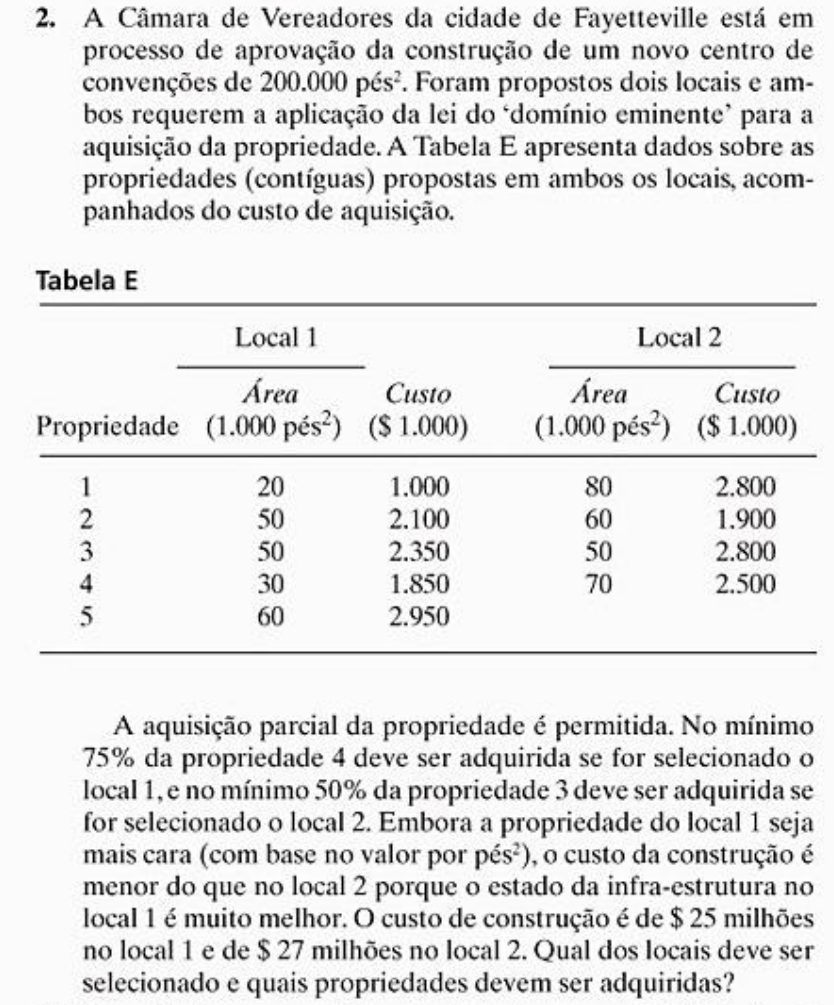

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Selecao_Local_Centro_Convencoes')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela E ---

# Identificadores
locais = ['local1', 'local2']
propriedades_l1 = [1, 2, 3, 4, 5]
propriedades_l2 = [1, 2, 3, 4]

# Custos de construção (em milhares de $)
custo_construcao = {'local1': 25000, 'local2': 27000}

# Área (em 1.000 pés²) e Custo de aquisição (em 1.000 $)
area_propriedade = {
    'local1': {1: 20, 2: 50, 3: 50, 4: 30, 5: 60},
    'local2': {1: 80, 2: 60, 3: 50, 4: 70}
}
custo_aquisicao = {
    'local1': {1: 1000, 2: 2100, 3: 2350, 4: 1850, 5: 2950},
    'local2': {1: 2800, 2: 1900, 3: 2800, 4: 2500}
}

# Requisitos do projeto
area_total_necessaria = 200 # em 1.000 pés²

In [4]:
# 1. Variáveis de Decisão

# Variáveis binárias para selecionar UM dos locais
local_selecionado = model.binary_var_dict(locais, name='Y')

# Variáveis contínuas para a fração (0 a 1) de cada propriedade a ser adquirida
fracao_adquirida = {
    'local1': model.continuous_var_dict(propriedades_l1, name='X1', lb=0, ub=1),
    'local2': model.continuous_var_dict(propriedades_l2, name='X2', lb=0, ub=1)
}


# 2. Função Objetivo
# Minimizar o custo total (Construção + Aquisição)
expressao_custo_constr = (custo_construcao[l] * local_selecionado[l] for l in locais)
soma_custo_constr = model.sum(expressao_custo_constr)

expressao_custo_aquis = (custo_aquisicao[l][p] * fracao_adquirida[l][p]
                         for l in locais for p in area_propriedade[l])
soma_custo_aquis = model.sum(expressao_custo_aquis)

custo_total = soma_custo_constr + soma_custo_aquis
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Selecionar exatamente um local
restr_selecao_local_logica = model.sum(local_selecionado[l] for l in locais) == 1
model.add_constraint(restr_selecao_local_logica, ctname='seleciona_um_local')

# Restrição 2: Atingir a área total necessária
expressao_area_total = (area_propriedade[l][p] * fracao_adquirida[l][p]
                        for l in locais for p in area_propriedade[l])
soma_area_total = model.sum(expressao_area_total)
restr_area_minima_logica = soma_area_total >= area_total_necessaria
model.add_constraint(restr_area_minima_logica, ctname='area_total_minima')

# Restrição 3: Vincular aquisição de propriedade à seleção do local
# Só se pode adquirir frações de uma propriedade se o seu local for escolhido (Y=1)
for l in locais:
    for p in area_propriedade[l]:
        restr_vinculo_logica = fracao_adquirida[l][p] <= local_selecionado[l]
        model.add_constraint(restr_vinculo_logica, ctname=f'vinculo_{l}_{p}')

# Restrição 4: Condições específicas de aquisição
# Se local 1 for escolhido, adquirir no mínimo 75% da propriedade 4
restr_cond_l1_logica = fracao_adquirida['local1'][4] >= 0.75 * local_selecionado['local1']
model.add_constraint(restr_cond_l1_logica, ctname='condicao_l1_p4')

# Se local 2 for escolhido, adquirir no mínimo 50% da propriedade 3
restr_cond_l2_logica = fracao_adquirida['local2'][3] >= 0.50 * local_selecionado['local2']
model.add_constraint(restr_cond_l2_logica, ctname='condicao_l2_p3')

docplex.mp.LinearConstraint[condicao_l2_p3](X2_3,GE,0.500Y_local2)

In [5]:
# Define um tempo limite para o solver (opcional)
model.parameters.timelimit = 120

# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Total Mínimo: ${custo_minimo:,.3f} (milhares de $)")

    print("\n--- Decisões ---")
    for l in locais:
        if local_selecionado[l].solution_value > 0.9:
            print(f"Local Selecionado: {l.upper()}")
            print("Frações das Propriedades a Adquirir:")
            for p in area_propriedade[l]:
                fracao = fracao_adquirida[l][p].solution_value
                if fracao > 1e-6: # Imprimir apenas se a fração for maior que zero
                    print(f"  - Propriedade {p}: {fracao:.2%}")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               120
Found incumbent of value 35250.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 2 times.
Aggregator did 1 substitutions.
Reduced MIP has 12 rows, 10 columns, and 31 nonzeros.
Reduced MIP has 1 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 12 rows, 10 columns, and 31 nonzeros.
Reduced MIP has 1 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.02 ticks)
Probing time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.00 sec. (0.02 ticks)

        Nodes                                      